In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc3 as pm
import arviz as az

sns.set_style("whitegrid")

# Использование нормальных моделей

Норальные модели чрезвычайно привлекательны с математической точки зрения, потому что с ними легко работать. Например, известно, что сопряженное априорное распределение  нормального распределения представляет собой само нормальное распределение. Кроме того, существует множество явлений, которые можно успешно аппроксимировать с помощью нормальной модели. 

Можно сказать, например, что рост (и почти все прочие подобные физические характеристики человека) является результатом воздействия множества факторов природной среды и множества генетических факторов, следовательно, мы получаем достаточно точное нормальное распределение для роста взрослых людей. 

Точнее говоря, мы получаем объединение двух нормальных распределений как результат совмещения распределений роста мужчин и женщин. 

В общем, с нормальными моделями легко работать, по своей природе они обладают множеством полезных характеристик, а многие статистические методы, с которыми вы, вероятно, уже знакомы, основаны на предположениях о нормальности. 

Поэтому важно хорошо знать, как создаются эти модели, но не менее важно знать, как сделать менее строгими предположения о нормальности. 

## Наша первая нормальная модель

Пусть у нас есть данные о "химическом сдвиге", полученных в ходе ядерного магнитного резонанса (ЯМР). Давайте попробуем понять, является ли нормальное распределение  приемлемой аппроксимацией для исследуемых данных. 

фильтр. среднее: 52.95261
фильтр. стд.откл: 2.19503
среднее: 53.49646
стд.откл: 3.42001


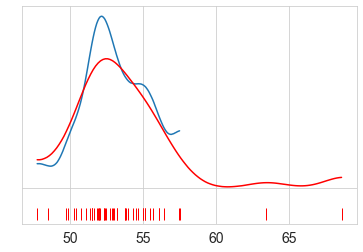

In [2]:
data = np.loadtxt('chem.csv')
# фильтр на данные
quant = np.percentile(data, [25, 75])
iqr = quant[1] - quant[0]
upper_b = quant[1] + iqr * 1.5
lower_b = quant[0] - iqr * 1.5
data_filtr = data[(data > lower_b) & (data < upper_b)]
print("фильтр. среднее: {:3.5f}\nфильтр. стд.откл: {:3.5f}".format(np.mean(data_filtr),np.std(data_filtr)))
print("среднее: {:3.5f}\nстд.откл: {:3.5f}".format(np.mean(data),np.std(data)))
az.plot_kde(data_filtr);
az.plot_kde(data, rug=True, plot_kwargs={"color": "red"});
plt.yticks([0], alpha=0);

График ЯОП (ядерной оценки плотности) для этого набора данных демонстрирует распределение, похожее на нормальное, за исключением двух точек данных, располагающихся далеко от среднего значения.
Давайте пока забудем об этих точках (синий график). И сформируем допустимую модель:
$$ \mu \sim U (l,h) $$
$$ \sigma \sim |N(0,\sigma_{\sigma})|$$
$$ y \sim N (\mu , \sigma)$$

Почему мы записали нашу модель в таком виде?

Если неизвестны возможные значения параметров $\mu$ и $\sigma$, то можно назначить априорные распределения, отображающие наше незнание. 

Один из вариантов подобного решения является задание математического ожидания как значениея из равновероятного диапазона превышаюшего диапазон исходных данных.
То есть $\mu$ вычисляется по равномерному распределению с нижней границей $l=40$ и верхней границей $h=60$. 

Другой из вариантов, возможность выбора диапазона на основе ранее полученных знаний. Очевидно, что $\sigma \ge 0$, и нам известно, что точность измерения высока и укладывается в диапазон  $\sigma \le 10$
Значение $\sigma$ определяется как полунормальное распределение со стандартным отклонением $\sigma_\sigma$. Полунормальное распределение похоже на обычное нормальное распределение, но ограничено только положительными значениями (включая ноль). 

Наконец, в этой модели данные y определяются нормальным распределением с параметрами $\mu$ и $\sigma$.

 ![](diag01.png)
 
Запишем нашу модель в виде следующего кода:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, mu]
Sampling 3 chains, 0 divergences: 100%|██████████| 4500/4500 [00:00<00:00, 5180.15draws/s]
The acceptance probability does not match the target. It is 0.8934744504238283, but should be close to 0.8. Try to increase the number of tuning steps.


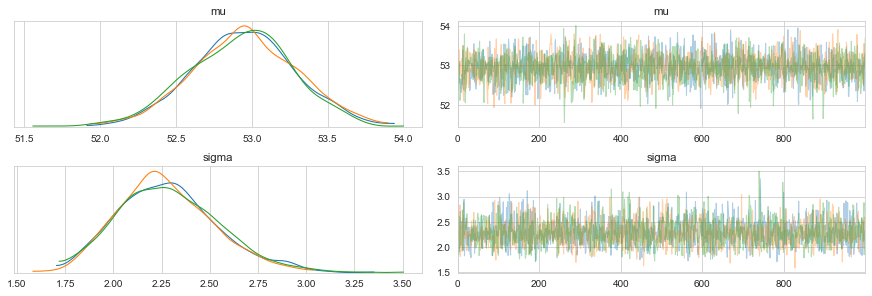

In [3]:
with pm.Model() as model_f:
    mu = pm.Uniform('mu', lower=40, upper=60)
    sigma = pm.HalfNormal('sigma', sd=10)
    y = pm.Normal('y', mu=mu, sd=sigma, observed=data_filtr)
    trace_f = pm.sample(1000, chains=3)
az.plot_trace(trace_f);

Для каждого параметра отведена отдельная строка графика. Для используемой модели апостериорное распределение двумерное, поэтому на схемах показаны предельные распределения для каждого параметра (проекции на плоскость трехмерной каринки).

Можно воспользоваться функцией <code>plot_joint</code> из библиотеки ArviZ, чтобы наглядно показать внешний вид двумерного апостериорного распределения совместно с предельными распределениями для параметров $\mu$ и $\sigma$:

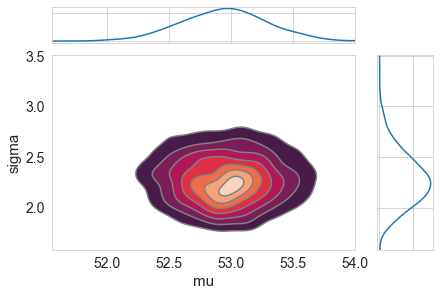

In [4]:
az.plot_joint(trace_f, kind='kde', fill_last=False);

Если необходим доступ к значениям любого параметра, сохраненным в объекте <code>trace</code>, то можно проиндексировать значения трассировки с помощью имени рассматриваемого параметра. Результатом этой операции является массив NumPy.

In [5]:
trace_f['sigma']

array([2.37543847, 2.00527182, 2.47848608, ..., 1.84797333, 1.98242303,
       2.11857251])

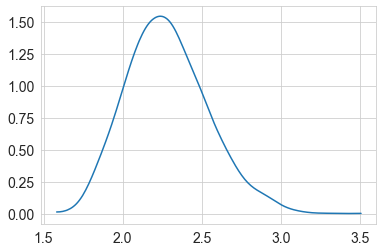

In [6]:
az.plot_kde(trace_f['sigma']);

Теперь выведем обобщенную сводку трассировки для дальнейшего использования

In [7]:
az.summary(trace_f)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,52.942,0.347,52.316,53.612,0.007,0.005,2423.0,2423.0,2440.0,2002.0,1.0
sigma,2.284,0.255,1.824,2.751,0.005,0.004,2527.0,2450.0,2583.0,2061.0,1.0


После вычисления апостериорного распределения можно использовать эти результаты для имитационных данных и для проверки согласованности (связности) имитационных данных с наблюдаемыми данными. 
С помощью библиотеки PyMC3 действительно легко получить выборки прогнозируемого апостериорного распределения, если воспользоваться функцией <code>sample_posterior_predictive</code>.
Есть 2 пути решения правильный и старый(кривоватый).

<b>Правильный</b>
    Для этого нам нужно преобразовать код исходной модели, а также необходимо помнить, что объем предсказательной модели составит равен произведению количества цепочек на сэмпл. 

In [8]:
with pm.Model() as model_fp:
    mu = pm.Uniform('mu', lower=40, upper=60)
    sigma = pm.HalfNormal('sigma', sd=10)
    y = pm.Normal('y', mu=mu, sd=sigma, observed=data_filtr)
    trace_fp = pm.sample(2000, chains=3)
    y_pred_fp = pm.sample_posterior_predictive(trace_fp)
    data_ppc = az.from_pymc3(trace=trace_fp, posterior_predictive=y_pred_fp)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, mu]
100%|██████████| 6000/6000 [00:03<00:00, 1688.55it/s]


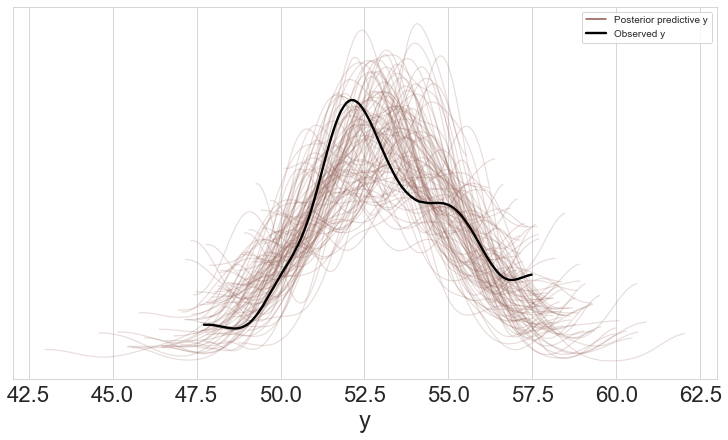

In [9]:
ax = az.plot_ppc(data_ppc, figsize=(10, 6), mean=False, num_pp_samples = 100);
ax[0].legend(fontsize=10);  

На схеме черная линия представляет ядерную оценку плотности на иисходных данных, а множественные полупрозрачные линии – это ЯОП, вычисленные для каждой из указанных выборок прогнозируемого апостериорного распределения. Эти полупрозрачные линии отображают неопределенность информации о статистически выведенном распределении прогнозируемых данных. 

Плотность оценивается в реальном диапазоне данных, передаваемых в функцию kde, тогда как вне этого диапазона плотность полагается равной нулю. 

Конечно можно считать это ошибкой (ведь мы говорим о непрерывных распределениях), но лучше это считать "полезным свойством", поскольку оно отображает реальную характеристику данных и не сглаживает их сверх меры.

<b>Старый вариант</b>
Работает быстрее. Может поправят проблему с переформатирование данных

In [10]:
with pm.Model() as model_fp_old:
    mu = pm.Uniform('mu', lower=40, upper=60)
    sigma = pm.HalfNormal('sigma', sd=10)
    y = pm.Normal('y', mu=mu, sd=sigma, observed=data_filtr)
    trace_fp_old = pm.sample(2000, chains=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, mu]
Sampling 3 chains, 0 divergences: 100%|██████████| 7500/7500 [00:01<00:00, 6001.85draws/s]


/Users/imachome/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 100/100 [00:00<00:00, 1305.48it/s]
arviz.data.io_pymc3 - WARNING - posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


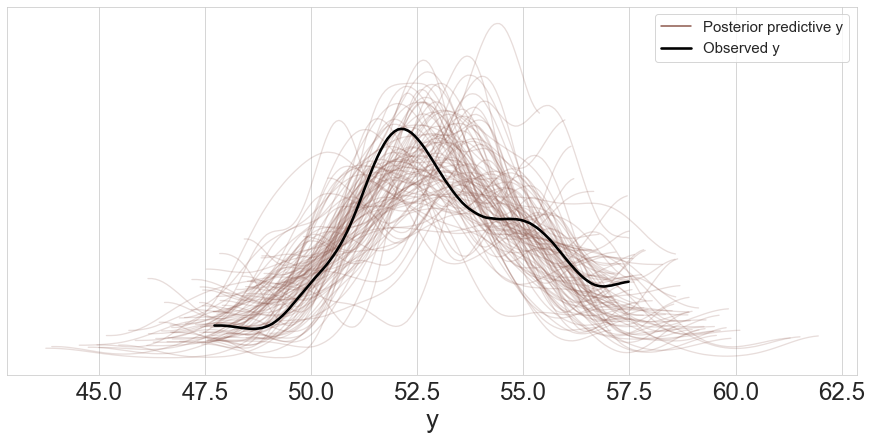

In [11]:
y_pred_fp_old = pm.sample_posterior_predictive(
    model=model_fp_old, 
    trace = trace_fp_old, 
    samples =100 )
data_ppc_old = az.from_pymc3(trace=trace_fp_old, posterior_predictive=y_pred_fp_old)

ax = az.plot_ppc(data_ppc_old, figsize=(12, 6), mean=False);
ax[0].legend(fontsize=15);

## Модель на полных данных

Одним из недостатков, присущих модели model_f, представленной в предыдущем разделе, является предварительное предположение о нормальном распределении, хотя в конце распределения имеются две точки данных, из-за которых такое предположение выглядит слегка натянутым, не совсем корректным. 

Посмотрите на результат моделирования с использованием полных данных:

In [12]:
with pm.Model() as model_o:
    mu = pm.Uniform('mu', lower=40, upper=70)
    sigma = pm.HalfNormal('sigma', sd=10)
    y = pm.Normal('y', mu=mu, sd=sigma, observed=data)
    trace_o = pm.sample(1000, chains=3)
    y_pred_o = pm.sample_posterior_predictive(trace_o)
    data_ppc_o = az.from_pymc3(trace=trace_o, posterior_predictive=y_pred_o)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, mu]
100%|██████████| 3000/3000 [00:01<00:00, 1684.22it/s]


------- было --------


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,52.942,0.347,52.316,53.612,0.007,0.005,2423.0,2423.0,2440.0,2002.0,1.0
sigma,2.284,0.255,1.824,2.751,0.005,0.004,2527.0,2450.0,2583.0,2061.0,1.0


------- стало --------


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,53.499,0.527,52.540,54.483,0.011,0.008,2437.0,2437.0,2437.0,1980.0,1.0
sigma,3.541,0.385,2.849,4.255,0.008,0.005,2488.0,2488.0,2488.0,2096.0,1.0


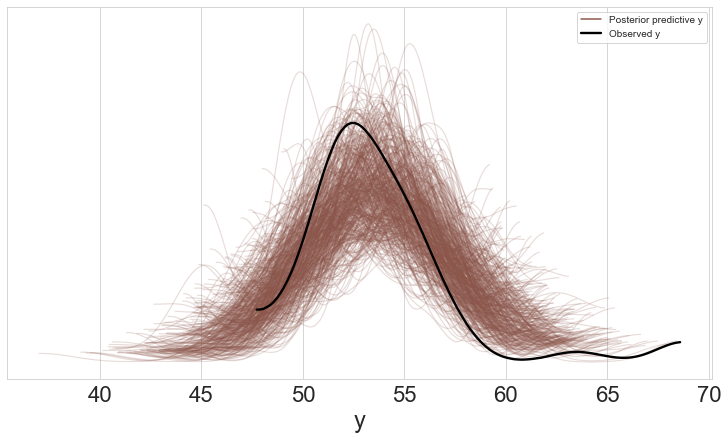

In [13]:
ax = az.plot_ppc(data_ppc_o, figsize=(10, 6), mean=False, num_pp_samples = 500);# max 0.7 от выборки
ax[0].legend(fontsize=10);  
print('------- было --------')
display(az.summary(trace_f))
print('------- стало --------')
display(az.summary(trace_o))

Поскольку концевые части графика нормального распределения быстро снижаются по мере удаления от среднего значения, для нормального распределения эти две точки выглядят не очень вероятным событием, а ответная реакция модели на их появление – увеличение стандартного отклонения. 

Обратите внгимание как сдвигается медиана и увеличивается стандартное отклонение.

Можно считать, что эти точки имеют избыточный вес при определении параметров нормального распределения. Какие меры могут исправить ситуацию?

## Распределение Стьюдента

В качестве обобщенного правила в байесовском анализе предпочтение отдается кодированию предварительных предположений напрямую в модель с использованием априорных распределений вероятностей и правдоподобий, а не применению специализированных для конкретных ситуаций эвристик, таких как правила исключения промахов.

Одним весьма полезным вариантом для обработки промахов при использовании нормальных распределений является замена нормального правдоподобия на распределение Стьюдента (t-распределение). 

Распределение Стьюдента имеет три параметра: среднее значение, коэффициент масштаба (аналогичен стандартному отклонению) и число степеней свободы, которое обычно обозначается греческой буквой $\nu$ и может изменяться в интервале $[0, \nu]$.

Будем называть параметр $\nu$ "параметром нормальности", так как он действительно управляет степенью "нормальости" распределения Стьюдента. 

При значении $\nu = 1$ мы получаем распределение с медленно убывающими (или широкими) хвостами, также известными как распределение Коши или распределение Лоренца. 
 Выражение «медленно убывающие (или широкие) хвосты» подразумевает, что вероятность обнаружения значений в более удаленных от среднего значения областях выше, чем в гауссовом распределении. 
Другими словами, значения не так плотно сконцентрированы в области, близкой к среднему значению, как в распределениях с быстро убывающими или узкими хвостами, подобных гауссову распределению. 
Например, 95 % значений из распределения Коши расположены между –12.7 и 12.7. Для сравнения: в нормальном распределении (со стандартным отклонением, равным единице) 95 % значений находятся в интервале от –1.96 до 1.96. 

На другой границе пространства параметров, где $\nu$ приближается к бесконечности, мы снова возвращаемся к гауссову распределению. 

Чрезвычайно любопытной особенностью распределения Стьюдента является тот факт, что при $\nu\le 1$ не определено среднее значение. 

Разумеется, на практике любая конечная выборка из распределения Стьюдента представляет собой обычный набор чисел, по которым всегда возможно вычислить эмпирическое среднее значение. 

Может ли в теоретическом распределении отсутствовать явно определенное среднее значение? Это можно понимать следующим образом: хвосты такого распределения настолько широки (убывают настолько медленно), что в любой момент может случиться так, что мы получим значение выборки практически из любой точки реальной линии, поэтому если сохранять получаемые числа, то никогда не удастся выполнить аппроксимацию по некоторому фиксированному значению. Вместо этого оценка будет непрерывно колебаться в окрестности данного значения.

В качестве примера:

In [14]:
for i in range(10):
    print ( np.mean(stats.t(loc=0, scale=1, df=1).rvs(1000)) )

-502.48933541124154
0.14425922121744367
1.224269108252723
-7.316430847121521
-9.111386440824305
-2.472161145689548
-1.0984295414921779
-0.27407405143119196
0.370596832331409
0.10261249352834846


Красивые картинки с распределением Стьюдента:

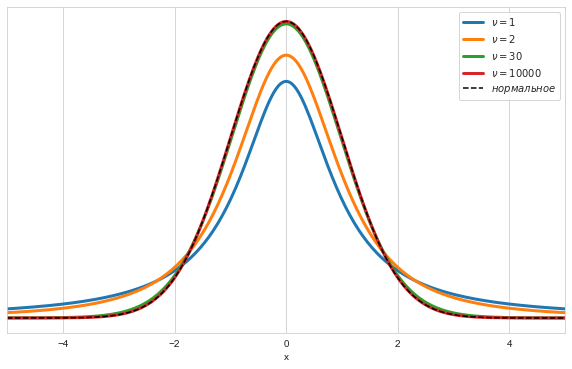

In [15]:
plt.figure(figsize=(10, 6))
x_values = np.linspace(-10, 10, 500)
for df in [1, 2, 30, 10000]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=fr'$\nu = {df}$', lw=3)

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, 'k--', label=r'$нормальное$');
plt.xlabel('x');
plt.yticks([]);
plt.legend();
plt.xlim(-5, 5);

В действительности на этой же схеме можно видеть, что большинство действий происходит при относительно малых значениях $\nu$. Следовательно, можно утверждать, что экспоненциальное априорное распределение со средним значением 30 является низкоинформативным априорным распределением, сообщающим модели, что мы более или менее уверены в том, что значение $\nu$ должно приблизительно равняться 30, но при этом с легкостью может принимать немного меньшие или немного большие значения. 

В большинстве задач оценка $\nu$ не является прямым объектом интереса.

Теперь нашу  модель можно представить следующей графической схемой:
 ![](diag02.png)
 
Обратите внимание, что экспоненциальная зависимость в библиотеке PyMC3 параметризуется как обратная величина среднему значению.

In [16]:
with pm.Model() as model_st:
    mu =    pm.Uniform('mu', 40, 70)
    sigma = pm.HalfNormal('sigma', sd=10)
    nu =    pm.Exponential('nu', 1/30)
    y =     pm.StudentT('y', mu=mu, sd=sigma, nu=nu, observed=data)
    trace_st = pm.sample(1000, chains=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [nu, sigma, mu]
Sampling 3 chains, 0 divergences: 100%|██████████| 4500/4500 [00:01<00:00, 3899.58draws/s]


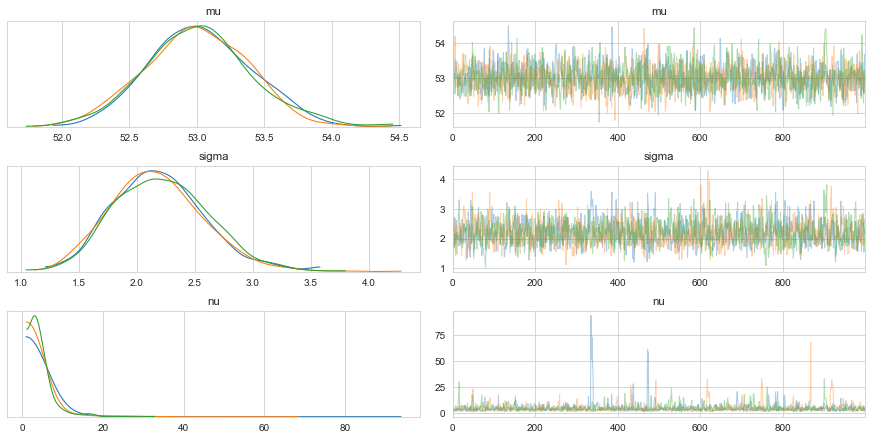

In [17]:
az.plot_trace(trace_st);

In [18]:
print('------- было --------')
display(az.summary(trace_o))
print('------- стало --------')
display(az.summary(trace_st))

------- было --------


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,53.499,0.527,52.540,54.483,0.011,0.008,2437.0,2437.0,2437.0,1980.0,1.0
sigma,3.541,0.385,2.849,4.255,0.008,0.005,2488.0,2488.0,2488.0,2096.0,1.0


------- стало --------


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,53.016,0.386,52.308,53.746,0.009,0.006,1766.0,1763.0,1799.0,1751.0,1.0
sigma,2.199,0.403,1.431,2.906,0.010,0.007,1553.0,1540.0,1564.0,1436.0,1.0
nu,4.779,4.731,1.120,9.538,0.164,0.118,828.0,807.0,1486.0,1150.0,1.0


Оценка $\mu$ в обеих моделях почти одинакова, значения различаются на $\approx 0.5$. Оценка $\sigma$ изменяется от $\approx 3.5$ до $\approx 2.1$. Это следствие того, что распределение Стьюдента присваивает меньший вес (то есть подвержено меньшему воздействию) значениям, удаленным от среднего значения. Также можно видеть, что $\nu \approx  4.5$, то есть мы получили не очень похожее на гауссово распределение, отличающееся от него более медленно убывающими (более широкими) хвостами.

Теперь выполним проверку прогнозируемого апостериорного распределения для модели Стьюдента.

In [19]:
with pm.Model() as model_2:
    mu =    pm.Uniform('mu', 40, 75)
    sigma = pm.HalfNormal('sigma', sd=10)
    nu =    pm.Exponential('nu', 1/30)
    y =     pm.StudentT('y', mu=mu, sd=sigma, nu=nu, observed=data)
    trace_2 = pm.sample(1000, chains=3)
    posterior_predictive = pm.sample_posterior_predictive(trace_2)
    idata_pymc3 = az.from_pymc3(
        trace_2,
        posterior_predictive=posterior_predictive
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [nu, sigma, mu]
Sampling 3 chains, 0 divergences: 100%|██████████| 4500/4500 [00:01<00:00, 3629.44draws/s]
The acceptance probability does not match the target. It is 0.8985954233366755, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 3000/3000 [00:01<00:00, 1982.29it/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,53.025,0.375,52.316,53.725,0.009,0.006,1864.0,1863.0,1873.0,1859.0,1.0
sigma,2.203,0.399,1.493,2.959,0.010,0.007,1631.0,1591.0,1681.0,1886.0,1.0
nu,4.607,4.248,1.250,9.183,0.135,0.096,989.0,989.0,1671.0,1238.0,1.0


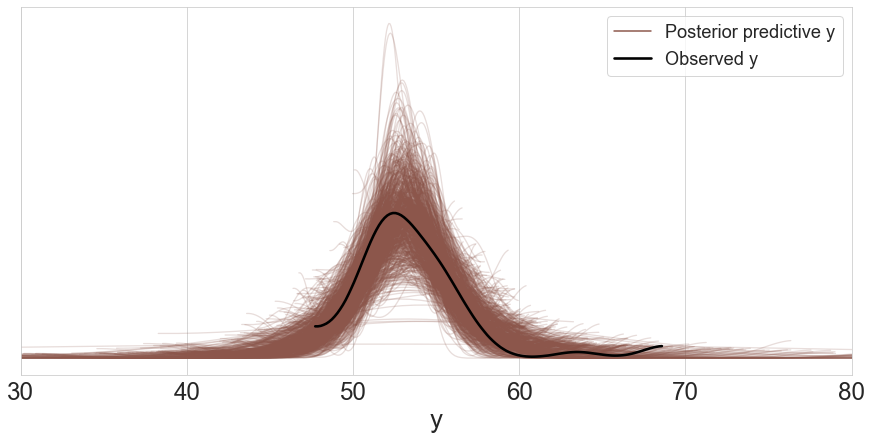

In [20]:
az.plot_ppc(idata_pymc3, figsize=(12, 6),mean=False, num_pp_samples = 800 );
ax[0].legend(fontsize=15);
plt.xlim(30, 80);
az.summary(trace_2)

Распределение Стьюдента позволяет получить более надежную оценку, так как воздействие промахов уменьшает значение $\nu$, а не смещает его в направлении промахов, увеличивая при этом стандартное отклонение. Таким образом, среднее значение и коэффициент масштаба оцениваются с учетом более значимых весов точек данных из основного массива по сравнению с точками данных вне его. 

Еще раз подчеркнем, что важно помнить о том, что коэффициент масштаба не является стандартным отклонением. Тем не менее коэффициент масштаба связан с размахом данных: чем меньше коэффициент масштаба, тем более компактным становится распределение. 

Кроме того, для значений $\nu\ge 2$ коэффициент масштаба становится весьма близким (по крайней мере, для большинства практических целей) к значениям, оцениваемым после удаления промахов. 

Поэтому в качестве практического правила для не слишком малых значений $\nu$ с учетом того, что это не вполне правильно с теоретической точки зрения, можно считать коэффициент масштаба распределения Стьюдента разумным практическим представлением, заменяющим стандартное отклнение для данных после удаления промахов.